In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [24]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:
batch_size = 128

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

# Generate random labels
random_labels = torch.randint(0, 10, (len(train_data),), dtype=torch.long)

# Assign random labels to the training dataset
train_data.targets = random_labels

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [26]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(64*7*7, 128)
    self.dense2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    return F.log_softmax(x, dim=1)

In [27]:
train_batch_size = 100
test_batch_size = 100
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

In [28]:
def train(model, optimizer, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss = []

    start_time = time.time()  # Start time

    for i, batch in enumerate(train_loader):
        images, labels = batch[0].to(device), batch[1].to(device)
        
        output = model(images)
        loss = loss_func(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

    elapsed_time = time.time() - start_time
    print(f"Epoch completed in: {elapsed_time:.2f} seconds")

    train_loss = sum(batch_loss) / len(train_loader.dataset)
    acc = 100. * correct / total_samples

    return train_loss, acc

In [29]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / total_samples

    return test_loss, accuracy

In [30]:
epochs = 100
model = Model().to(device)
optimizer1 = optim.Adam(model.parameters(), lr=1e-4)

train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, optimizer1, training_DataLoader)
    test_loss, test_acc = test(model, testing_DataLoader)

    print(f'Epoch - {epoch} Train Loss - {train_loss:.6f} Test Loss - {test_loss:.6f} Train Accuracy - {train_acc:.6f} Test Accuracy - {test_acc:.6f}')

    train_loss_arr.append(train_loss)
    test_loss_arr.append(test_loss)

Epoch completed in: 9.07 seconds
Epoch - 0 Train Loss - 0.018013 Test Loss - 0.018182 Train Accuracy - 10.136667 Test Accuracy - 10.200000
Epoch completed in: 9.07 seconds
Epoch - 1 Train Loss - 0.017989 Test Loss - 0.018193 Train Accuracy - 10.806667 Test Accuracy - 14.130000
Epoch completed in: 9.05 seconds
Epoch - 2 Train Loss - 0.017971 Test Loss - 0.018152 Train Accuracy - 11.673333 Test Accuracy - 12.770000
Epoch completed in: 9.05 seconds
Epoch - 3 Train Loss - 0.017946 Test Loss - 0.018204 Train Accuracy - 12.030000 Test Accuracy - 9.480000
Epoch completed in: 9.06 seconds
Epoch - 4 Train Loss - 0.017912 Test Loss - 0.018129 Train Accuracy - 12.576667 Test Accuracy - 12.640000
Epoch completed in: 9.11 seconds
Epoch - 5 Train Loss - 0.017873 Test Loss - 0.018219 Train Accuracy - 13.226667 Test Accuracy - 12.440000
Epoch completed in: 9.37 seconds
Epoch - 6 Train Loss - 0.017825 Test Loss - 0.018183 Train Accuracy - 13.965000 Test Accuracy - 11.830000
Epoch completed in: 9.06 sec

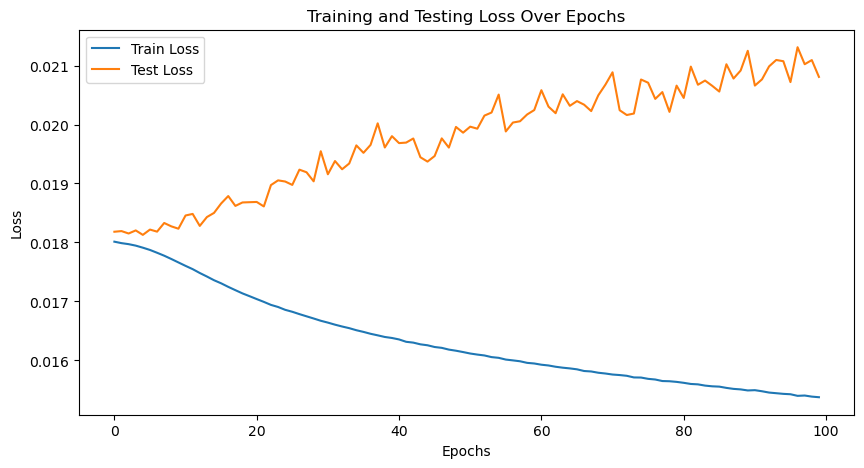

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_arr, label='Train Loss')
plt.plot(test_loss_arr, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()